In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt

### Objective Function and Constraints
- Q-learning Function
    - $Q(s,a)=r+γa ′max​Q(s′,a′)$
- Loss Function
    - $L(θ)=E[(y−Q(s,a;θ))^2]$

### Constraints
- State Space Constraints
    -  $S={x,x′,θ,θ′}$
        - $x$ : Cart position $(−2.4≤x≤2.4)4
        - $x'$ : Cart velocity (real-valued, no restriction)
        - $𝜃$ : Pole angle $(−12≤θ≤12,−0.21≤θ≤0.21 radians)$
        - $𝜃'$ : Pole angular velocity (real-valued, no restriction)
- Termination Conditions
    - The episode terminates when
        - Cart position limit exceeded
            - $∣x∣>2.4$ ⇒ Terminate Episode
        - Pole angle limit exceeded
            - $∣θ∣>12$ ⇒ Terminate Episode
        - Maximum step limit reached
            - t≥max_steps⇒Terminate Episode

### Optimization Problem
- Objective Function
    - $min_{𝜃}L(𝜃) = E[(r+\gamma max_{a'}(s',a';𝜃^{-})-Q(s,a;𝜃^{-}))]$
- $S.t$
    - $x∈[−2.4,2.4],θ∈[−0.21,0.21] (라디안)$
    - $a∈{0,1}$
    - $t≤max steps$​

In [2]:
import math
from typing import Optional, Union

import numpy as np

import gym
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled


class CartPoleEnv(gym.Env):
    def __init__(self, render_mode: Optional[str] = "human", max_steps: int = 50):
        super().__init__()
        self.max_steps = max_steps  # 시간 제한 스텝 수
        self.current_step = 0      # 현재 스텝 수 초기화
        self.render_mode = render_mode 
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # 실제 폴의 절반 길이
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # 상태 업데이트 간격 (초)
        self.kinematics_integrator = "euler"

        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # 추가: 안정성 임계값
        self.x_stable_threshold = 0.5  # 안정성 판단을 위한 x 위치 임계값
        self.theta_stable_threshold = 0.05  # 안정성 판단을 위한 각도 임계값
        self.stable_steps = 0  # 안정적 유지 시간 초기화

        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                self.theta_threshold_radians * 2,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state = None
        self.steps_beyond_terminated = None

        # Spec 속성 설정
        self.spec = type('', (), {'id': "CustomCartPole-v0"})()


    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * theta_dot**2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        self.current_step += 1  # 스텝 카운터 증가
        terminated = bool(
            x < -self.x_threshold or x > self.x_threshold  # 좌우 제한
            or self.current_step >= self.max_steps         # 시간 제한
        )

        distance_reward = 1 - math.fabs(x / self.x_threshold)
        angle_reward = 1 - math.fabs(theta / self.theta_threshold_radians)
        force_penalty = (force / self.force_mag) ** 2

        stability_bonus = 0
        if math.fabs(x) < self.x_stable_threshold and math.fabs(theta) < self.theta_stable_threshold:
            self.stable_steps += 1
            stability_bonus = self.stable_steps * 0.01
        else:
            self.stable_steps = 0

        reward = (angle_reward * 0.7 + distance_reward * 0.3) - force_penalty * 0.01 + stability_bonus
        reward = max(reward, 0)

        if terminated:
            reward = 0.0  # 종료 시 보상 없음

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}


    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        self.current_step = 0  # 스텝 카운터 초기화
        self.state = np.array([0.0, 0.0, np.pi, 0.0], dtype=np.float32)  # 초기 상태 설정
        self.steps_beyond_terminated = None

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [3]:
# 커스텀 환경 생성
env = CartPoleEnv(render_mode="rgb_array", max_steps=200)
state, _ = env.reset()
print("Custom initial state:", state)

Custom initial state: [0.        0.        3.1415927 0.       ]


네트워크

In [4]:
# Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.fc3(x)

In [5]:
import torch

# Hyperparameters
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 5e-4
UPDATE_EVERY = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [7]:
# Agent
class Agent:
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 and len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # NumPy를 사용해 랜덤 선택
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.choice(np.arange(self.action_size))  # random.choice -> np.random.choice


    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)
        q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [9]:
# dqn 함수 수정
def dqn(n_episodes=10000, max_t=200, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning with the Custom CartPole Environment."""
    scores = []
    scores_window = deque(maxlen=100)  # 마지막 100개의 점수
    eps = eps_start  # 초기 탐욕 정책 비율

    for i_episode in range(1, n_episodes + 1):
        state, _ = env.reset()  # 환경 초기화
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)  # 행동 선택
            next_state, reward, done, _, _ = env.step(action)  # 환경 진행
            agent.step(state, action, reward, next_state, done)  # 학습 단계
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)  # 최근 점수 기록
        scores.append(score)  # 전체 점수 기록
        eps = max(eps_end, eps_decay * eps)  # 탐욕 정책 감소
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode - 100} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.qnetwork_local.state_dict(), 'cartpole_checkpoint.pth')  # 모델 저장
            break

        if i_episode == n_episodes:
            torch.save(agent.qnetwork_local.state_dict(), 'cartpole_checkpoint.pth')
    return scores



agent = Agent(state_size=4, action_size=2, seed=0)
scores = dqn()

Episode 100	Average Score: 0.10
Episode 200	Average Score: 0.34
Episode 300	Average Score: 0.11
Episode 400	Average Score: 0.04
Episode 500	Average Score: 0.27
Episode 600	Average Score: 0.20
Episode 700	Average Score: 0.48
Episode 800	Average Score: 1.04
Episode 900	Average Score: 1.00
Episode 1000	Average Score: 1.17
Episode 1100	Average Score: 1.91
Episode 1200	Average Score: 1.68
Episode 1300	Average Score: 1.44
Episode 1400	Average Score: 1.20
Episode 1500	Average Score: 3.28
Episode 1600	Average Score: 2.35
Episode 1700	Average Score: 9.34
Episode 1800	Average Score: 11.83
Episode 1900	Average Score: 15.19
Episode 2000	Average Score: 6.231
Episode 2100	Average Score: 13.23
Episode 2200	Average Score: 40.78
Episode 2300	Average Score: 41.84
Episode 2400	Average Score: 60.70
Episode 2500	Average Score: 102.55
Episode 2600	Average Score: 87.342
Episode 2700	Average Score: 80.83
Episode 2800	Average Score: 64.61
Episode 2900	Average Score: 59.93
Episode 3000	Average Score: 71.87
Epis

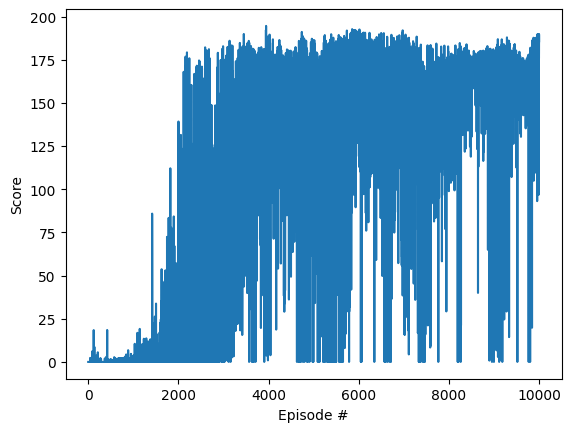

In [10]:
# Visualization
fig = plt.figure()
ax = fig.add_subplot(111) 
plt.plot(np.arange(len(scores)), scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [13]:
#테스트

from gym.wrappers import RecordVideo
import gym
import torch
import base64
import glob
import io
from IPython.display import HTML, display

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]  # 첫 번째 mp4 파일 선택
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env):
    # 비디오 녹화 설정
    env = RecordVideo(env, video_folder="video/", episode_trigger=lambda x: True)
    
    # 모델 로드
    agent.qnetwork_local.load_state_dict(torch.load('cartpole_checkpoint.pth'))
    state, _ = env.reset()  # 상태 초기화
    done = False

    while not done:
        # 에이전트가 행동 선택
        action = agent.act(state)
        # 반환 값 처리
        step_result = env.step(action)
        
        # 반환값 구조 처리
        if len(step_result) == 5:  # 최신 Gym 반환값 구조
            next_state, reward, terminated, truncated, _ = step_result
            done = terminated or truncated
        elif len(step_result) == 4:  # 구버전 Gym 반환값 구조
            next_state, reward, done, _ = step_result
        else:
            raise ValueError("Unexpected step result format: {}".format(step_result))

        state = next_state

    env.close()
    print("Video recording complete. Check the 'video/' folder.")


# 에이전트 생성 및 비디오 녹화 실행
# CustomCartPoleEnv 생성
env = CartPoleEnv(render_mode="rgb_array", max_steps=200)

# 에이전트 생성 및 비디오 녹화 실행
agent = Agent(state_size=4, action_size=2, seed=0)
show_video_of_model(agent, env)
show_video('CartPoleEnv')




C:\Users\fu268\AppData\Local\Temp\ipykernel_18172\1872814850.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.qnetwork_local.load_state_dict(torch.load('cartpole_c

MoviePy - Building video c:\Cart_Pole_dqn_ac\dqn\video\rl-video-episode-0.mp4.
MoviePy - Writing video c:\Cart_Pole_dqn_ac\dqn\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready c:\Cart_Pole_dqn_ac\dqn\video\rl-video-episode-0.mp4
Video recording complete. Check the 'video/' folder.
